# CHEN 5595 Homework 10

This HW focuses on linear models for classification. It consists only of coding exercises. I provide several definitions and hints throughout that will help you.  If you are confused about anything, do not panic, send us a message on Piazza! We are here to help you learn.

Please answer the numerical exercises using an ipython notebook **in [Google Colab](https://colab.research.google.com/)** (provide the link with your handwritten homework). **Please answer each coding problem  in a different cell**.

You can also view this ipython notebook in your browser through [binder](https://mybinder.org/v2/gh/smcantab/chen5595-fall2020/b389546a03f6e273293255bcca52d5c2acc7fd3f?filepath=homework%2Fhw10-questions.ipynb) or through nbviewer [link](https://nbviewer.jupyter.org/github/smcantab/chen5595-fall2020/blob/master/homework/hw10-questions.ipynb).

## Linear Models for Classification

Consider the following python function to generate synthetic data $\{\mathbf{x}_n, t_n\}$ consisting of 2-dimensional input vectors $\mathbf{x}_n$ and target variables $t_n=\{0, 1\}$, with $n=1, \dots, N$ with or without outliers.

In [1]:
import numpy as np

def create_toy_data(n0=25, n1=25, n_outliers=0):
    """
    Generates 2d Gaussian point clouds for binary classification problem
    with or without outliers
    
    n0: int
        number of points in class C0
    n1: int
        number of points in class C1
    n_outliers : int
        number of outliers of class C1
    """
    np.random.seed(42)
    x0 = np.random.normal(size=(n0, 2)) - 1
    x1 = np.random.normal(size=(n1, 2)) + 1.
    if n_outliers > 0:
        x_1 = np.random.normal(size=(n_outliers, 2)) + np.array([5., 10])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(n0), np.ones(n1+n_outliers)]).astype('int')
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(n0), np.ones(n1)]).astype('int')

Which we plot as an example below, first without outliers and then with outliers

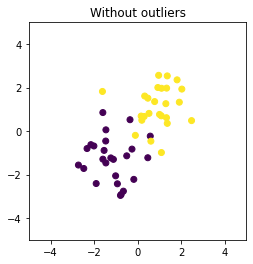

In [2]:
import matplotlib.pyplot as plt
x_train, y_train = create_toy_data(25, 25, 0)
fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
_ = ax.set_title('Without outliers')

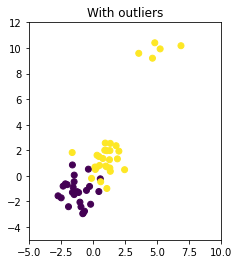

In [38]:
x_out_train, y_out_train = create_toy_data(25, 25, 5)
fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(x_out_train[:, 0], x_out_train[:, 1], c=y_out_train)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 12)
ax.set_aspect('equal', adjustable='box')
_ = ax.set_title('With outliers')

In what follows we will implement and compare the performance of different classification algorithms, namely least squares classification, the perceptron and logistic regression.

### Problem 1

To derive least square classification for K classes, we start by defining a linear model for each class $k$

$$y_k(\mathbf{x}) = \mathbf{w}_k^\top \mathbf{x} + w_{k0} $$

where $k=1, \dots, K$. We group all of them into a single equation

$$\mathbf{y}(\mathbf{x}) =  \tilde{\mathbf{W}}^\top \tilde{\mathbf{x}}$$

where $\tilde{\mathbf{W}}$ is a matrix whose k-th column comprises the $D+1$ dimensional vector $\tilde{\mathbf{w}}_k = (w_{k0}, \mathbf{w}_k^\top)^\top$, and $\tilde{\mathbf{x}} = (1, \mathbf{x}^\top)^\top$ is the augmented input vector. A new input $\mathbf{x}$ is classified according to which class has largest outpyt $y_k = \tilde{\mathbf{w}}^\top_k \tilde{\mathbf{x}}$.

Now consider a dataset $\{\mathbf{x}_n, t_n\}$ and define a matrix $\mathbf{T}$ whose n-th row is the 1-of-K (one-hot) encoded vector $\mathbf{t}_n^\top$, together with a matrix $\tilde{\mathbf{X}}$ whose n-th row is $\tilde{\mathbf{x}}_n^\top$. We can thus introduce the sum-of-squares error function

$$E_D(\tilde{\mathbf{W}}) = \frac{1}{2} \mathrm{Tr} \left \{ \left ( \tilde{\mathbf{X}}\tilde{\mathbf{W}} -  \mathbf{T} \right)^\top \left ( \tilde{\mathbf{X}}\tilde{\mathbf{W}} -  \mathbf{T} \right) \right \} $$

with exact minimizer

$$ \tilde{\mathbf{W}}_{ML} = \tilde{\mathbf{X}}^\dagger \mathbf{T}$$

where $\tilde{\mathbf{X}}^\dagger$ is the pseudo-inverse of matrix $\tilde{\mathbf{X}}$. We then obtain a discriminant function in the form

$$ \mathbf{y}(\mathbf{x}) = \tilde{\mathbf{W}}^\top_{ML} \tilde{\mathbf{x}}$$

Implement a class for the least squares classifier of the form

```python
class LeastSquaresClassifier(object):

    def fit(self, X, t):
        """
        X : (N, D) np.ndarray
           training input variables
        t : (N,K) np.ndarray
            training target variables in 1-of-K coding
        """
        self.W = # fit model parameters

    def classify(self, X):
        """
        X : (N, D) np.ndarray
            unseed input variables
        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return #list of classification labels
```

Then fit `x_train, y_train` and `x_out_train, y_out_train`, for each produce a graph showing the individual points colored according to the predicted class and color the background according to the predicted class that would be assigned to each region of space (e.g. you could do this using the matplotlib function [`contourf`](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contourf_demo.html)). Provide a justification for the behaviour that you observe in each case.

### Problem 2

The perceptron algorithm is an iterative algorithm to solve a binary classification problem that aims to minimize the so-called _perceptron criterion_ given by

$$ E_P = - \sum_{n \in \mathcal{M}} \mathbf{w}^\top \mathbf{\phi}_n t_n$$

where $\mathbf{\phi}_n = \mathbf{\phi}(\mathbf{x}_n)$ is a set of linear basis functions, $\mathcal{M}$ denotes the set of all misclassified patters, and $t_n = \{-1, 1\}$ is a binary label. To minimize the perceptron criterion we apply the stochastic gradient descent (SGD) alogirthm

$$ \mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \nabla E_P(\mathbf{w}) = \mathbf{w}^{(\tau+1)} + \mathbf{\phi}_n t_n$$

where we have implicitely taken the training rate to be $\eta=1$ without loss of generality. In other words, we cycle through the training patterns in turn, and for each pattern $\mathbf{x}_n$ we evaluate the perceptron function

$$ y(\mathbf{x}) = \mathrm{sign}\left(\mathbf{w}^\top \phi(\mathbf{x}) \right)$$

If the pattern is correctly classified, then the weight vector remains unchanged, if the pattern is incorrectly misclassified, then we add $\mathbf{\phi}_n t_n$ to the weight vector (as prescribed by SGD). 

Take $\mathbf{\phi}_n=\mathbf{x}_n$ and implement the perceptron using a class of the form

```python
class Perceptron(object):

    def fit(self, X, t, max_iter=100):
        """
        X : (N, D) np.ndarray
            training input variables
        t : (N,)
            training target variable (binary -1 or 1)
        max_iter : int, optional
            maximum number of iterations (the default is 100)
        """
        self.w = np.zeros(np.size(X, 1))
        # write a for loop to iteratively update the weight vector self.w
        # until it doesn't change anymore or max_iter is exceeded

    def classify(self, X):
        """
        X : (N, D) np.ndarray
            input variables to be classified
        Returns
        -------
        (N,) np.ndarray
            binary class (-1 or 1) for each input
        """
        return #perceptron function evaluated on X
```

Perform the classification as in Problem 1 and generate the same figure but using the perceptron. In addition, generate 4 plots showing the evolution of the decision boundary as a function of iterations (you can allow for multiple steps in between).

### Problem 3

Logistic regression is an approach to binary classification that directly models the posterior probability of class $\mathcal{C}_1$ in terms of a generalized linear model of the form

$$p(\mathcal{C}_1|\mathbf{\phi}) = y(\mathbf{\phi}) = \sigma \left( \mathbf{w}^\top \mathbf{\phi}\right) $$

with $p(\mathcal{C}_2|\mathbf{\phi}) = 1 - p(\mathcal{C}_1|\mathbf{\phi})$, and $\sigma(\cdot)$ is the logistic sigmoid function. This is called _logistic regression_ (even though it is a model for classification, not regression). The error function for the logistic sigmoid is (the negative log-likelihood)

$$E(\mathbf{w}) = - \sum_{n=1}^{N} \left \{ t_n \log y_n + (1-t_n) \log (1-y_n) \right \}$$

The solution to logistic regression cannot be found in closed form due to the nonlinearity of the logistic sigmoid function. Nevertheless the error function is convex, and a solution can be found efficiently by _Newton-Raphson_ iterative optimization, which leads to so-called _iterative reweighted least squares_ (IRLS). The Newton-Raphson update formula is

$$\mathbf{w}^{(\mathrm{new})} = \mathbf{w}^{(\mathrm{old})} - \mathbf{H}^{-1} \nabla E(\mathbf{w}) = (\mathbf{\Phi}^\top \mathbf{R} \mathbf{\Phi})^{-1}\mathbf{\Phi}^\top (\mathbf{y} - \mathbf{t})$$

where $\mathbf{R}$ is an $N \times N$ diagonal matrix called _reweighting matrix_ with elements

$$R_{nn} = y_n (1-y_n)$$

and we used

$$ \nabla E (\mathbf{w}) = \mathbf{\Phi}^\top (\mathbf{y} - \mathbf{t}) $$

$$\mathbf{H} = \nabla \nabla E (\mathbf{w}) = \mathbf{\Phi}^\top \mathbf{R} \mathbf{\Phi} $$

Take $\mathbf{\phi}_n=\mathbf{x}_n$ and implement the perceptron using a class of the form

```python
class LogisticRegression(object):

    def sigmoid(a):
        return np.tanh(a * 0.5) * 0.5 + 0.5

    def fit(self, X, t, max_iter=100):
        """
        X : (N, D) np.ndarray
            training input variable
        t : (N,) np.ndarray
            training target variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of iterations (the default is 100)
        """
        w = np.zeros(np.size(X, 1))
        # implement the Newton Raphson scheme to update the value of w until convergence
        # or until max_iter has been exceeded
        self.w = w

    def probability(self, X):
        """
        X : (N, D) np.ndarray
            training input variable
        Returns
        -------
        (N,) np.ndarray
            posterior probability of class C1
        """
        return #probability of X belonging to C1

    def classify(self, X, threshold):
        """
        X : (N, D) np.ndarray
            unseen input variable to be classified
        threshold : float, optional
            threshold of binary classification (default is 0.5)
        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        return #labels for X
```

Perform the classification as in Problem 1 and generate the same figure but using logistic regression. This time color the background of the graphs according to the probabilities, not the predicted class. Provide a justification for the behaviour that you observe in each case when compared with the perceptron and least square classification.